In [55]:
from NN import SimpleNN
from LR_pt import LogisticRegression
import torch
import os as os
from data_loader import data_loader, preprocess
from models import one_hot_cols, features
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report
from fairlearn.metrics import equalized_odds_difference
import matplotlib
from PCA import fair_PCA
import xgboost as xgb
import torch

In [81]:
def load_data():
    one_hot = True

    num_samples = 1_000_000
    df = data_loader(one_hot_cols, num=num_samples)

    # filter columns to only include columns in the features list below
    if 'race_ethnicity' in features:
       # remove  'race_ethnicity' from features
           features.remove('race_ethnicity')
    else: 
           print("'race_ethnicity' not in features")
    x_train, x_val, x_test, y_train,y_val , y_test, train_groups, val_groups,test_groups = preprocess(df, features, one_hot_cols)
    print(f'All rows in train_groups sum to 1: {np.allclose(np.sum(train_groups, axis=1), 1)}')

    # convert y_train, y_val, y_test to numpy arrays
    y_train = y_train.to_numpy()
    y_val = y_val.to_numpy()
    y_test = y_test.to_numpy()

load_data()

Loading data...
processed_data.csv exists. Loading data from file.
'race_ethnicity' not in features
x_train: 70.00%
x_val: 15.00%
x_test: 15.00%
Num features BEFORE filtering features 54
Num features AFTER filtering features 11
x_train shape:  (395460, 11)
y_train shape:  (84742, 11)
All rows in train_groups sum to 1: True


In [46]:
def load_models(num_classes, models_directory):
    models = {}

    for filename in os.listdir(models_directory):
        if 'F:False' in filename:  # ignore l2 model
            continue

        full_path = os.path.join(models_directory, filename)

        if filename.endswith('.pt'):  # if the file is a PyTorch model
            print(f'Loading PyTorch model {filename}')
            state_dict = torch.load(full_path)

            # Infer input size from state dictionary
            for param_tensor in state_dict:
                if param_tensor.endswith(".weight"):  # find the weight tensor of the first linear layer
                    input_size = state_dict[param_tensor].size(1)  # assuming the second dimension is input_size
                    break

            if filename.startswith('NN'):
                model_name = "NN"
                if "pca:True" in filename:
                    model = SimpleNN(6, num_classes)  
                    model_name += "_FairPCA"
                else:
                    model = SimpleNN(input_size, num_classes)
            elif filename.startswith('LRmodel'):
                model = LogisticRegression(input_size)
                model_name = "LR"
                if "F:True" in filename:
                    model_name += "_FairLoss"
                if "_odds" in filename:
                    model_name += "_eqodds"
                if "fairpca" in filename:
                    model_name += "_FairPCA"

            model.load_state_dict(state_dict)
            models[model_name] = model

    return models


In [47]:
models = load_models( 2, '../models')
print(models.keys())  



Loading PyTorch model NN_pca:False_E:50_lr:0.0001_bs:512.pt
Loading PyTorch model NN_pca:True_E:50_lr:0.0001_bs:512.pt
Loading PyTorch model LRmodel_S:1000000_E:2000_F:NO l2_L:1_G:0.1.pt
Loading PyTorch model LRmodel_S:1000000_E:2000_F:True_L:1_G:2.575.pt
Loading PyTorch model LRmodel_S:1000000_E:2000_F:NO l2_L:1_G:2.575_fairpca.pt
dict_keys(['NN', 'NN_FairPCA', 'LR', 'LR_FairLoss', 'LR_FairPCA'])


In [56]:
def evaluate_models(models, x_train, x_test, y_test, test_groups):
    plt.style.use('bmh')
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    # list of metric names
    metric_names = ['f1-weighted', 'f1-class0', 'f1-class1', 'mu_equalized_odds', 'equalized_odds']

    # dictionary to hold metric values for each model
    metric_values = {model_name: {metric: [] if metric == 'equalized_odds' else None for metric in metric_names} for model_name in models.keys()}

    metric_names.remove('equalized_odds')  # remove equalized odds difference from metric names
    # sort models such that LR_FairPCA is first, then LR, then NN_FairPCA, then NN

    for model_name, model in models.items():
        print()
        print(f'Evaluating {model_name}...')
        print("_____________________________\n")
        if model_name == 'NN_FairPCA':
            X_fair_PCA, U, explained_variance = fair_PCA(x_train, n_components=x_train.shape[1], groups=train_groups)
            x_train = X_fair_PCA
            x_test_pca = x_test @ U

        # get model predictions
        if model_name.startswith('NN'):
            # argmax of softmax output is the predicted class
            if model_name == 'NN_FairPCA':
                test_preds = model(x_test_pca).detach().numpy().argmax(axis=1)
            else:
                test_preds = model(x_test).detach().numpy().argmax(axis=1)
        elif model_name.startswith('xgboost'):
            if 'xgboost_model_fair' in model_name:
                test_preds = model.predict(xgb.DMatrix(x_test_pca)) > 0.5
            else:
                test_preds = model.predict(xgb.DMatrix(x_test)) > 0.5
        else:
            # logistic regression outputs probabilities
            if model_name == 'LR_FairPCA':
                test_preds = model(x_test_pca).detach().numpy() > 0.5
            else:
                test_preds = model(x_test).detach().numpy() > 0.5
        print(f"Test preds: {test_preds.shape}, {test_preds[:2]}, y_test: {y_test.shape}, {y_test[:2]}")
        # calculate weighted f1 score
        weighted_f1 = f1_score(y_test, test_preds, average='weighted')
        

        # calculate f1 score for class 0
        f1_score_0 = f1_score(y_test, test_preds, pos_label=0)

        # calculate f1 score for class 1
        f1_score_1 = f1_score(y_test, test_preds, pos_label=1)

        # calculate mean equalized odds difference
        one_hot_cols = list(range(6))

        mean_eod = np.mean([
            equalized_odds_difference(y_test, test_preds, sensitive_features=test_groups[:, one_hot_cols.index(col)])
            for col in one_hot_cols
        ])
        metric_values[model_name]['equalized_odds'].extend([
            equalized_odds_difference(y_test, test_preds, sensitive_features=test_groups[:, one_hot_cols.index(col)])
            for col in one_hot_cols
        ])

        # calculate weighted f1 score and other metrics
        metric_values[model_name]['f1-weighted'] = weighted_f1
        metric_values[model_name]['f1-class0'] = f1_score_0
        metric_values[model_name]['f1-class1'] = f1_score_1
        metric_values[model_name]['mu_equalized_odds'] = mean_eod
        print(f'Weighted F1: {weighted_f1:.4f}')
        print(f'F1 score (class 0): {f1_score_0:.4f}')
        print(f'F1 score (class 1): {f1_score_1:.4f}')
        print(f'Mean equalized odds: {mean_eod:.4f}')

        print(classification_report(y_test, test_preds))

    return metric_values, metric_names


In [57]:
metric_values, metric_names = evaluate_models(models, x_train, x_test, y_test, test_groups)


Evaluating NN...
_____________________________

Test preds: (84742,), [0 0], y_test: (84742,), [0 1]
Weighted F1: 0.7051
F1 score (class 0): 0.4077
F1 score (class 1): 0.7822
Mean equalized odds: 0.1044
              precision    recall  f1-score   support

           0       0.33      0.53      0.41     17455
           1       0.86      0.72      0.78     67287

    accuracy                           0.68     84742
   macro avg       0.59      0.63      0.59     84742
weighted avg       0.75      0.68      0.71     84742


Evaluating NN_FairPCA...
_____________________________

Test preds: (84742,), [1 1], y_test: (84742,), [0 1]
Weighted F1: 0.7226
F1 score (class 0): 0.3451
F1 score (class 1): 0.8206
Mean equalized odds: 0.0768
              precision    recall  f1-score   support

           0       0.33      0.36      0.35     17455
           1       0.83      0.81      0.82     67287

    accuracy                           0.72     84742
   macro avg       0.58      0.59      

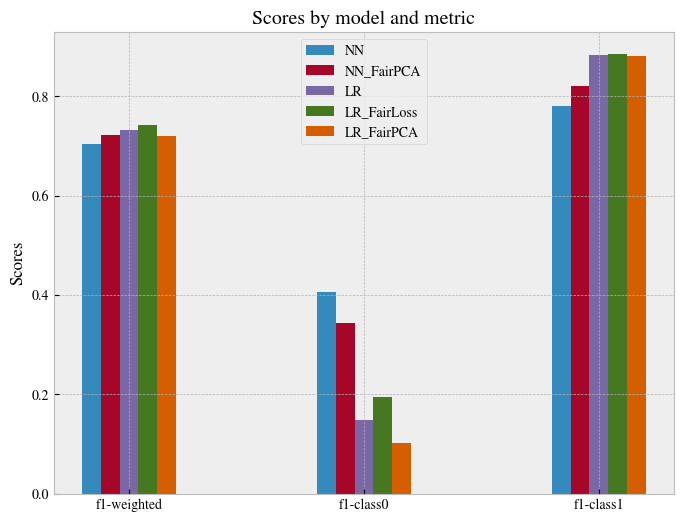

<Figure size 640x480 with 0 Axes>

In [50]:
def eval_plot(models, metric_names, metric_values):
    x = np.arange(len(metric_names))  # the label locations
    num_models = len(models)
    width = 0.4 / num_models  # Adjust the total width based on the number of models

    fig, ax = plt.subplots(figsize=(8, 6))
    for i, model_name in enumerate(models.keys()):
        scores = [metric_values[model_name][metric] for metric in metric_names]
        offset = i - (num_models - 1) / 2  # Calculate the offset for positioning the bars
        ax.bar(x + offset * width, scores, width, label=model_name)

    # Add some text for labels, title, and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Scores by model and metric')
    ax.set_xticks(x)
    ax.set_xticklabels(metric_names)
    ax.legend()

    plt.show()
    plt.savefig('../plots/model_performance.png')

# create bar chart
try:
    metric_names.remove('mu_equalized_odds')
except:
    pass
eval_plot(models, metric_names, metric_values)

In [51]:
def plot_equalized_odds_difference(metric_values, models):
    # Create a list of model names sorted alphabetically
    model_names = sorted(models.keys())

    # Create a 2D list where each sublist contains the 'equalized_odds_difference' values for each group of a model
    eod_values = [metric_values[model_name]['equalized_odds'] for model_name in model_names]

    # Transpose the 2D list to group values by group instead of by model
    eod_values = list(map(list, zip(*eod_values)))

    # Assume that the number of groups is the length of the first sublist in eod_values
    num_groups = len(eod_values)

    # Set the width of the bars
    bar_width = 0.1

    # Set the opacity for the bars
    opacity = 1

    # Create an array for the positions of the bars on the x-axis
    index = np.arange(len(model_names))

    # Plot a group of bars for each group
    for group in range(num_groups):
        plt.bar(index + group * bar_width, eod_values[group], bar_width,
                alpha=opacity,
                label=f'{one_hot_cols[group]}')

    # Add labels, title, and legend
    plt.xlabel('Model')
    plt.ylabel('Equalized Odds Difference')
    plt.title('Equalized Odds Difference by Model and Group')
    plt.xticks(index + bar_width * (num_groups - 1) / 2, model_names)  # center the x-ticks
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()
    plt.savefig('../plots/equalized_odds_difference_by_model_and_group')


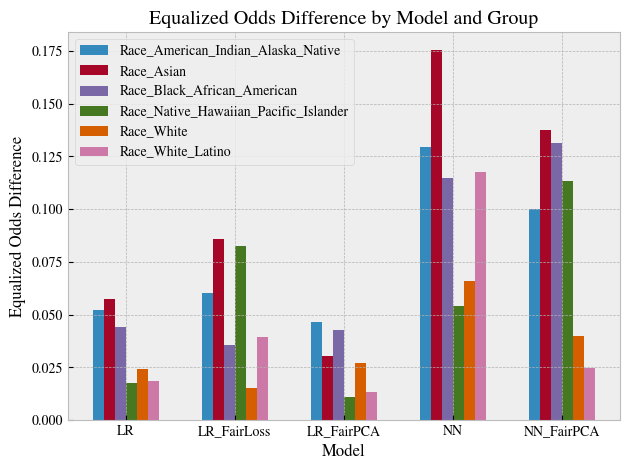

<Figure size 640x480 with 0 Axes>

In [52]:
plot_equalized_odds_difference(metric_values, models)

In [54]:
for model_name in sorted(models.keys()):
    print(metric_values[model_name]['equalized_odds']) 

[0.0521331093450601, 0.057563666004917025, 0.043953255032788685, 0.017577103217594425, 0.02432328047611554, 0.018567586679743453]
[0.060310737367299305, 0.08581171691142642, 0.0355008461958769, 0.08261022199695078, 0.015328874145636995, 0.03932326426215704]
[0.04654186859274012, 0.030283259489094272, 0.042812679927654695, 0.010860565416730195, 0.02692223780501557, 0.013343152050717899]
[0.12967514040589612, 0.1752152877295855, 0.11463936323927132, 0.05413084581828076, 0.06608260305827746, 0.11769434764487485]
[0.09999568633095035, 0.13738775456541463, 0.13150187368643507, 0.11353480292623608, 0.039726823984222115, 0.024537648482018226]
